In [12]:
import os
import numpy as np
import re
import sys
import importlib.util
import shutil
import matplotlib.pyplot as plt
import neurite as ne

In [13]:
# Import a file from D:\study\graduation project\GP-2025-Strain\Code\ventricular_short_axis_3label\docs\localize.py
base_path = os.getcwd()

# Define the path to the file
file_path = os.path.join(base_path, "../ventricular_short_axis_3label\docs\localize.py")

# Add the directory containing the file to the system path
sys.path.append(os.path.dirname(file_path))

# Import the module
spec = importlib.util.spec_from_file_location("localize", file_path)
localize = importlib.util.module_from_spec(spec)
spec.loader.exec_module(localize)

from localize import Localize

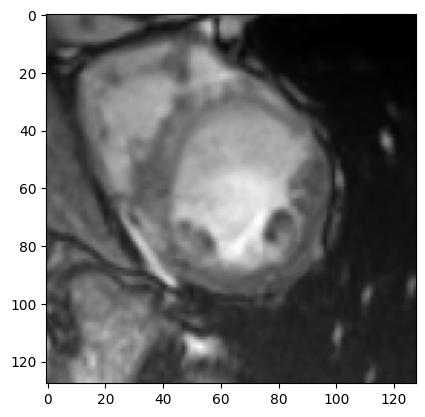

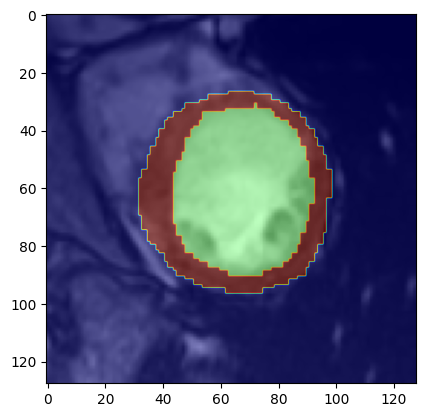

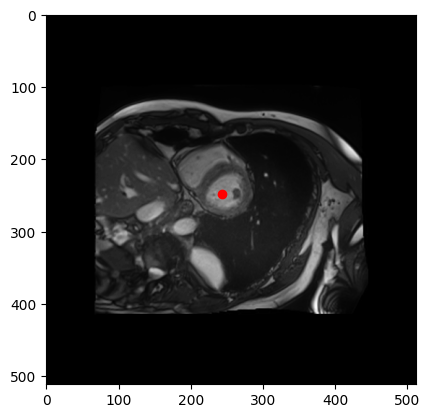

In [14]:
file_to_localize = os.path.join(base_path, "../../Data/ACDC/database/train_numpy/patient055")
Localizer = Localize(file_to_localize)  # path to the time series folder
image = Localizer.get_cropped_image(4)
mask = Localizer.get_cropped_mask(4)
Localizer.plot_image(image)
Localizer.plot_image_seg(image, mask)
Localizer.view_center_of_mass(2)

In [21]:
def process_acdc_patient(patient_path):
    """
    Process a single patient folder from the ACDC dataset, and apply localization.
    
    Args:
        patient_path (str): Path to the patient folder.

    Returns:
        np.ndarray: Array containing pairs of consecutive frames, each with image and mask.
    """
    pattern = r"frame(\d+)_slice_(\d+)"
    slices_dict = {}

    for file in os.listdir(patient_path):
        if file.endswith(".npy"):
            file_path = os.path.join(patient_path, file)
            data = np.load(file_path)  # Shape: (2, H, W)

            # Extract slice and frame numbers from the filename
            match = re.search(pattern, file)
            if not match:
                print(f"Error: {file} does not match the expected pattern.")
                continue
            frame = int(match.group(1))
            slice_num = int(match.group(2))

            # Organize frames by slice number
            if slice_num not in slices_dict:
                slices_dict[slice_num] = []
            slices_dict[slice_num].append((frame, data))

    paired_frames = []

    for slice_num, frames in slices_dict.items():
        # Ensure there are at least two frames for pairing
        if len(frames) < 2:
            print(f"Warning: Slice {slice_num} does not have enough frames to pair.")
            continue

        # Pair consecutive frames
        for i in range(len(frames) - 1):
            _, frame1_data = frames[i]
            _, frame2_data = frames[i + 1]

            # Localize both frames
            localized_frame1 = localize_slices(np.expand_dims(frame1_data, axis=0))[0]
            localized_frame2 = localize_slices(np.expand_dims(frame2_data, axis=0))[0]

            # Combine the localized frames into a single pair
            pair = np.stack([localized_frame1, localized_frame2], axis=0)  # Shape: (2, 2, H, W)
            paired_frames.append(pair)

    return np.array(paired_frames)  # Shape: (num_pairs, 2, 2, H, W)



def localize_slices(slice_array):
    """
    Apply the Localize class to localize a set of slices (images and masks).

    Args:
        slice_array (np.ndarray): Slices in the shape (num_slices, 2, H, W).

    Returns:
        np.ndarray: Localized slices of shape (num_slices, 2, crop_size, crop_size).
    """
    localized_images = []
    localized_masks = []

    for i in range(slice_array.shape[0]):
        image = slice_array[i, 0]  # Image
        mask = slice_array[i, 1]   # Mask

        # Save temporary numpy files to feed into Localize (as it expects paths)
        temp_dir = "temp_localization"
        os.makedirs(temp_dir, exist_ok=True)
        temp_file = os.path.join(temp_dir, f"slice_{i}.npy")
        np.save(temp_file, np.stack([image, mask]))

    # Instantiate Localize and localize
    Localizer = Localize(temp_dir)

    for j in range(len(Localizer.array_of_cropped_images)):
        localized_images.append(Localizer.array_of_cropped_images[j])
        localized_masks.append(Localizer.array_of_cropped_masks[j])

    # Clean up temp directory
    shutil.rmtree(temp_dir)

    # Combine localized images and masks
    return np.stack([localized_images, localized_masks], axis=1)

def process_sunnybrook_patient(patient_path):
    """
    Process a single patient folder from the Sunnybrook dataset, with localization applied.
    
    Args:
        patient_path (str): Path to the patient folder.

    Returns:
        list: A list containing localized end-systole and end-diastole slices.
    """
    pattern = r"frame(\d+)"
    frames = []

    # Load frames
    for file in sorted(os.listdir(patient_path)):
        if file.endswith(".npy"):
            file_path = os.path.join(patient_path, file)
            data = np.load(file_path)  # Shape: (2, H, W)
            frames.append((file, data))

    # Apply localization
    localized_frames = []
    localizer = Localize(patient_path)  # Pass the entire time series path to Localize

    for idx, (file, data) in enumerate(frames):
        # Get cropped image and mask
        cropped_image = localizer.get_cropped_image(idx)
        cropped_mask = localizer.get_cropped_mask(idx)

        # Recombine the localized image and mask
        localized_data = np.stack([cropped_image, cropped_mask], axis=0)
        localized_frames.append(localized_data)

    # Create pairs of consecutive frames
    paired_frames = []
    for i in range(len(localized_frames) - 1):
        paired_frames.append(np.stack([localized_frames[i], localized_frames[i + 1]], axis=0))

    return np.array(paired_frames)  # Shape: (num_pairs, 2, 2, H, W)


def load_and_organize_data(input_path, dataset_type):
    """
    Load and organize data from the ACDC and Sunnybrook datasets.
    
    Args:
        input_path (str): Path to the directory containing the dataset folders.
        dataset_type (str): Type of dataset ('ACDC' or 'Sunnybrook').

    Returns:
        np.ndarray: A NumPy array with shape (num_patients, max_num_pairs, 2 frames, 2 image/mask, H, W).
    """
    all_patient_data = []

    for patient_folder in os.listdir(input_path):
        patient_path = os.path.join(input_path, patient_folder)
        if not os.path.isdir(patient_path):
            continue

        if dataset_type == 'ACDC':
            print(f"Processing patient {patient_folder} in the ACDC dataset...")
            patient_data = process_acdc_patient(patient_path)
        elif dataset_type == 'Sunnybrook':
            print(f"Processing patient {patient_folder} in the Sunnybrook dataset...")
            patient_data = process_sunnybrook_patient(patient_path)
        else:
            raise ValueError("Unsupported dataset type. Choose 'ACDC' or 'Sunnybrook'.")

        # Add the processed data for this patient to the list
        all_patient_data.append(patient_data)

    return all_patient_data


def load_combined_data(acdc_path, sunnybrook_path, output_path):
    """
    Load and combine data from both ACDC and Sunnybrook datasets, ensuring unified per-patient slices.

    Args:
        acdc_path (str): Path to the ACDC dataset.
        sunnybrook_path (str): Path to the Sunnybrook dataset.
        output_path (str): Path to save the combined dataset.

    Returns:
        np.ndarray: Combined patient data as a NumPy array.
    """
    # Load data from both datasets
    acdc_data_list = load_and_organize_data(acdc_path, 'ACDC')
    sunnybrook_data_list = load_and_organize_data(sunnybrook_path, 'Sunnybrook')

    # Find the maximum number of pairs across both datasets
    max_num_pairs = max(
        max(acdc_data.shape[0] for acdc_data in acdc_data_list),
        max(sunnybrook_data.shape[0] for sunnybrook_data in sunnybrook_data_list)
    )

    # Pad both datasets to the same number of pairs
    padded_acdc_data = []
    for acdc_data in acdc_data_list:
        num_pairs = acdc_data.shape[0]
        if num_pairs < max_num_pairs:
            pad_size = max_num_pairs - num_pairs
            padding = np.zeros((pad_size, *acdc_data.shape[1:]))  # Shape: (pad_size, 2, 2, H, W)
            padded_acdc_data.append(np.concatenate([acdc_data, padding], axis=0))
        else:
            padded_acdc_data.append(acdc_data)

    padded_sunnybrook_data = []
    for sunnybrook_data in sunnybrook_data_list:
        num_pairs = sunnybrook_data.shape[0]
        if num_pairs < max_num_pairs:
            pad_size = max_num_pairs - num_pairs
            padding = np.zeros((pad_size, *sunnybrook_data.shape[1:]))  # Shape: (pad_size, 2, 2, H, W)
            padded_sunnybrook_data.append(np.concatenate([sunnybrook_data, padding], axis=0))
        else:
            padded_sunnybrook_data.append(sunnybrook_data)

    # Combine both datasets
    combined_data = np.concatenate([padded_acdc_data, padded_sunnybrook_data], axis=0)

    # Save combined data to a file
    np.save(output_path, combined_data)

    return combined_data

In [22]:
acdc_path = os.path.join(base_path, "../../Data/ACDC/database/train_numpy")
sunnybrook_path = os.path.join(base_path, "../../Data/Sunnybrook/Standardized_Numpy")
output_path = os.path.join(base_path, "../../Data/combined_data.npy")

combined_data = load_combined_data(acdc_path, sunnybrook_path, output_path)
print(f"Combined data shape: {combined_data.shape}")


Processing patient patient001 in the ACDC dataset...
Processing patient patient002 in the ACDC dataset...
Processing patient patient003 in the ACDC dataset...
Processing patient patient004 in the ACDC dataset...
Processing patient patient005 in the ACDC dataset...
Processing patient patient006 in the ACDC dataset...
Processing patient patient007 in the ACDC dataset...
Processing patient patient008 in the ACDC dataset...
Processing patient patient009 in the ACDC dataset...
Processing patient patient010 in the ACDC dataset...
Processing patient patient011 in the ACDC dataset...
Processing patient patient012 in the ACDC dataset...
Processing patient patient013 in the ACDC dataset...
Processing patient patient014 in the ACDC dataset...
Processing patient patient015 in the ACDC dataset...
Processing patient patient016 in the ACDC dataset...
Processing patient patient017 in the ACDC dataset...
Processing patient patient018 in the ACDC dataset...
Processing patient patient019 in the ACDC data

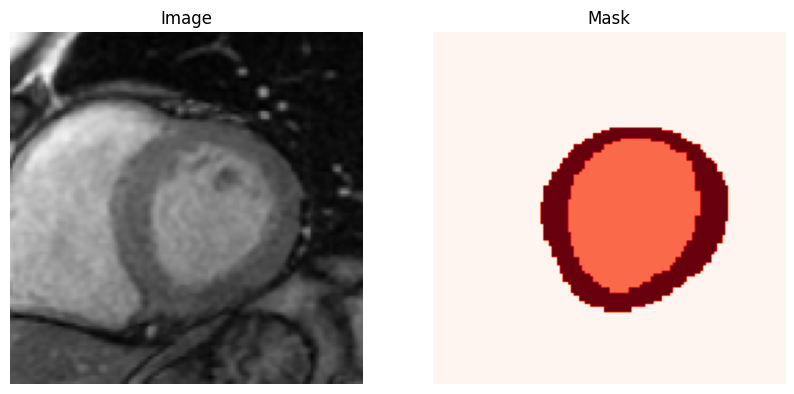

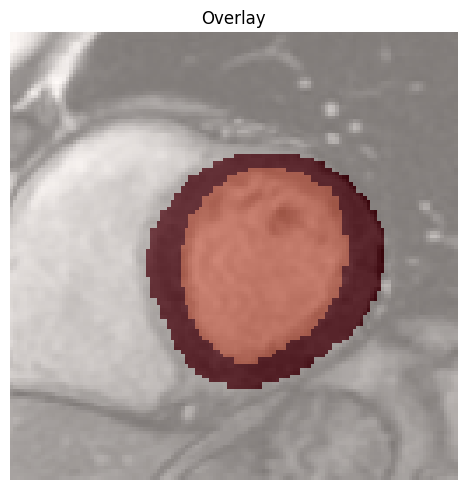

In [26]:
def plot_sample_slice(combined_data, patient_index=0, stage=0, slice_index=0):
    """
    Plots a sample slice from the combined dataset.

    Args:
        combined_data (np.ndarray): Combined dataset of shape 
                                     (num_patients, max_slices, 2, 2, 128, 128).
        patient_index (int): Index of the patient to visualize. Default is 0.
        stage (int): Index of the stage to visualize (0 = end-systole, 1 = end-diastole). Default is 0.
        slice_index (int): Index of the slice to visualize. Default is 0.
    """
    try:
        # Extract the image and mask
        sample_image = combined_data[patient_index, slice_index, stage, 0]
        sample_mask = combined_data[patient_index, slice_index, stage, 1]

        # Create the plots
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(sample_image, cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(sample_mask, cmap='Reds')
        plt.title('Mask')
        plt.axis('off')

        # Plot the image and mask overlay
        plt.figure(figsize=(5, 5))
        plt.imshow(sample_image, cmap='gray')
        plt.imshow(sample_mask, cmap='Reds', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except IndexError:
        print("Invalid index provided. Ensure the patient_index, stage, and slice_index are within bounds.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Load the combined data
combined_data = np.load(output_path)
# Example usage
plot_sample_slice(combined_data, patient_index=143, stage=1, slice_index=0)


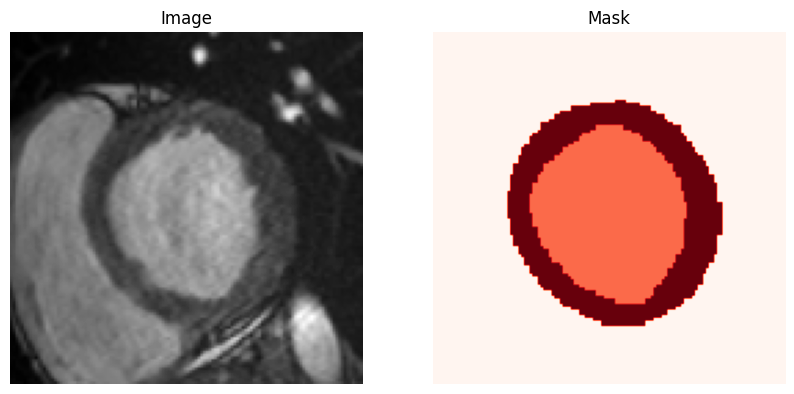

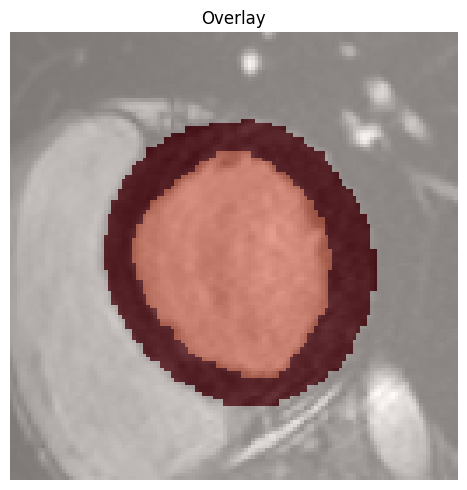

In [27]:
plot_sample_slice(combined_data, patient_index=77, stage=0, slice_index=0)

In [28]:
# Make sure there is no zero value image frames in the dataset
zero_images = []
for i in range(combined_data.shape[0]):
    for j in range(combined_data.shape[1]):
        if np.sum(combined_data[i, j, 0, 0]) == 0:
            zero_images.append((i, j))
print(f"Number of zero-value image frames: {len(zero_images)}")


Number of zero-value image frames: 1285
